## Use OpenCV to get frames from url

In [1]:
import cv2

# HLS playlist URL
hls_url = "https://streamer4.brownrice.com/camdensnowbowl1/camdensnowbowl1.stream/main_playlist.m3u8"

cap = cv2.VideoCapture(hls_url)

frame_count = 0
frame_skip = 100  # Skip every 5 frames

if not cap.isOpened():
    print("Error: Could not open the HLS stream.")
else:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Frame not received, ending stream")
            break
        frame_count += 1
        if frame_count % frame_skip != 0:
            continue
        # Process your frame (e.g., people counting) here

        # For debugging, display the frame
        cv2.imshow("HLS Stream", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in ""


## Count People in Web Cam Using YOLOv8

In [ ]:
import cv2
from ultralytics import YOLO
import numpy as np
import torch
import os

# Import the necessary classes - this is a new issue with pytorch 2.6, could use 2.4 and not have to import all of these layers and add them to the globals list
from ultralytics.nn.tasks import DetectionModel  # Already imported for YOLOv8 models
from torch.nn.modules.container import Sequential    # For Sequential layers
from ultralytics.nn.modules.conv import Conv         # For Conv layers defined by Ultralytics
from torch.nn.modules.conv import Conv2d              # For PyTorch's Conv2d layer
from torch.nn.modules.batchnorm import BatchNorm2d
from torch.nn.modules.activation import SiLU               # PyTorch's SiLU activation
from ultralytics.nn.modules.block import C2f                       # Ultralytics' C2f block
from torch.nn.modules.container import ModuleList
from ultralytics.nn.modules.block import Bottleneck
from ultralytics.nn.modules.block import SPPF
from torch.nn.modules.pooling import MaxPool2d
from torch.nn.modules.upsampling import Upsample
from ultralytics.nn.modules.conv import Concat
from ultralytics.nn.modules.head import Detect
from ultralytics.nn.modules.block import DFL
torch.serialization.add_safe_globals([
    DetectionModel, Sequential, Conv, Conv2d, BatchNorm2d, SiLU, C2f, ModuleList,
    Bottleneck, SPPF, MaxPool2d, Upsample, Concat, Detect, DFL
])

from src.config.config import frame_capture_settings


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load the pretrained YOLOv8 model and move it to the appropriate device
model = YOLO(os.path.join(frame_capture_settings.model_path, frame_capture_settings.model_name)).to(device)
print(model.names)

# Define the HLS stream URL (the direct stream URL you extracted)
hls_url = "https://streamer4.brownrice.com/camdensnowbowl1/camdensnowbowl1.stream/main_playlist.m3u8"

# Open the video stream
cap = cv2.VideoCapture(hls_url)
if not cap.isOpened():
    print("Error: Could not open the video stream.")
    exit()

frame_skip = 20  # Process every 20th frame
frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break
    frame_count += 1

    # Skip frames until we hit the desired interval
    if frame_count % frame_skip != 0:
        continue

    # Run YOLOv8 inference on the current frame.
    results = model(frame)
    
    # We'll use a copy of the frame to draw annotations.
    annotated_frame = frame.copy()
    people_count = 0

    # Process each detection result
    for result in results:
        if result.boxes is not None:
            boxes = result.boxes.data.cpu().numpy()  # shape: (num_boxes, 6)
            for box in boxes:
                x1, y1, x2, y2, conf, cls = box
                # In COCO, the 'person' class typically has an id of 0.
                if int(cls) >= 0:
                    bbox_color = (0, 255, 0)  # Green
                    if cls != 0:
                        bbox_color = (255, 0, 0)
                    cv2.rectangle(annotated_frame, (int(x1), int(y1)), (int(x2), int(y2)), bbox_color, 2)
                    people_count += 1
                    # Draw the bounding box and label on the frame.
                    cv2.putText(
                        annotated_frame,
                        f"{int(cls)} {conf:.2f}",
                        (int(x1), int(y1) - 10),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5,
                        (0, 255, 0),
                        2,
                    )
    
    # Overlay the people count on the frame.
    cv2.putText(
        annotated_frame,
        f"People Count: {people_count}",
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 0, 255),
        2,
    )
    
    # Display the annotated frame
    cv2.imshow("YOLOv8 People Counting", annotated_frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Release the stream and close windows
cap.release()
cv2.destroyAllWindows()


## Create a dataset we can use to fine tune the model for counting people on this web cam
Saves every 1000th frame into the dataset/images/train folder and the associated YOLOv8 detected people annotations into the dataset/labels/train folder

Idea is we then go through these images after we gather a lot and improve upon the annotations. Then we fine tune the YOLO model with this data.

In [ ]:
import os
import cv2
import time
from ultralytics import YOLO
import torch

# Set up safe globals for PyTorch 2.6+ (include only if necessary)
from ultralytics.nn.tasks import DetectionModel
from torch.nn.modules.container import Sequential, ModuleList
from ultralytics.nn.modules.conv import Conv, Concat
from torch.nn.modules.conv import Conv2d
from torch.nn.modules.batchnorm import BatchNorm2d
from torch.nn.modules.activation import SiLU
from ultralytics.nn.modules.block import C2f, Bottleneck, SPPF, DFL
from torch.nn.modules.pooling import MaxPool2d
from torch.nn.modules.upsampling import Upsample
from ultralytics.nn.modules.head import Detect
torch.serialization.add_safe_globals([
    DetectionModel, Sequential, Conv, Conv2d, BatchNorm2d, SiLU, C2f, ModuleList,
    Bottleneck, SPPF, MaxPool2d, Upsample, Concat, Detect, DFL
])

# Adjustable parameters
WEBCAM_URL = "https://streamer4.brownrice.com/camdensnowbowl1/camdensnowbowl1.stream/main_playlist.m3u8"
FRAME_INTERVAL = 1000  # Process every 1000th frame
CONF_THRESHOLD = 0.4   # Confidence threshold
IMG_DIR = 'dataset/images/train'
LABEL_DIR = 'dataset/labels/train'


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load YOLOv8 model
model = YOLO("yolov8n.pt").to(device)

cap = cv2.VideoCapture(WEBCAM_URL)
if not cap.isOpened():
    print("Error: Could not open the video stream.")
    exit()

frame_count = 0

while True:
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break

    frame_count += 1
    # Process only every FRAME_INTERVAL frame
    if frame_count % FRAME_INTERVAL != 1:
        continue

    # Save the raw frame
    timestamp = int(time.time())
    img_filename = os.path.join(IMG_DIR, f"frame_{frame_count}_{timestamp}.jpg")
    cv2.imwrite(img_filename, frame)
    print(f"Saved image: {img_filename}")

    # Run YOLOv8 inference on the frame
    results = model(frame)
    height, width = frame.shape[:2]

    # Open a .txt file for writing the annotations in YOLO format
    txt_filename = os.path.splitext(img_filename)[0] + ".txt"
    txt_filename = txt_filename.replace("images", "labels")
    with open(txt_filename, "w") as f:
        for result in results:
            if result.boxes is not None:
                boxes = result.boxes.data.cpu().numpy()  # each row: [x1, y1, x2, y2, conf, cls]
                for box in boxes:
                    x1, y1, x2, y2, conf, cls = box
                    if conf >= CONF_THRESHOLD and int(cls) == 0:  # Only person (class 0)
                        # Convert bounding box to YOLO format (normalized)
                        x_center = ((x1 + x2) / 2.0) / width
                        y_center = ((y1 + y2) / 2.0) / height
                        bbox_width = (x2 - x1) / width
                        bbox_height = (y2 - y1) / height
                        # Write annotation line: class x_center y_center width height
                        f.write(f"0 {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")
    print(f"Saved annotations: {txt_filename}")

    # Optionally, display the frame (with no annotations drawn)
    #cv2.imshow("Dataset Collection", frame)


cap.release()
cv2.destroyAllWindows()

In [ ]:
import os
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Hardcoded folder path (change this to your folder)
folder_path = 'datasets/dataset_webcam/labels/train'
model_path = 'finetune/yolo11l_external_finetune/weights/best.pt'
model = YOLO(model_path)

def get_yolo_boxes_from_annotation_file(annotation_file):
    boxes = []
    if not os.path.exists(annotation_file):
        print(f"Annotation file not found: {annotation_file}")
        return boxes  # return empty list if no file
    with open(annotation_file, 'r') as f:
        lines = f.readlines()
    for line in lines:
        # Each line: "class_id x_center y_center width height"
        box = line.strip().split(' ')
        if len(box) != 5:
            continue  # skip invalid lines
        box = [float(x) for x in box]
        boxes.append(box)
    return boxes

def draw_box(yolo_box, height, width, ax):
        """Draw a rectangle for a box in YOLO format and return the patch."""
        xc = yolo_box[1] * width
        yc = yolo_box[2] * height
        w = yolo_box[3] * width
        h = yolo_box[4] * height
        x0 = xc - w/2
        y0 = yc - h/2
        patch = plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)
        ax.add_patch(patch)
        

# Loop over all items in the folder
for filename in os.listdir(folder_path):
    annotation_path = os.path.join(folder_path, filename)
    img_filename = filename.replace('.txt', '.jpg')
    img = cv2.imread(os.path.join(folder_path, img_filename))
    if img is None:
        print(f"Image {img_filename} not found.")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    boxes = get_yolo_boxes_from_annotation_file(annotation_path)
    if not boxes:
        print(f"No boxes found in {annotation_path}")
        continue

    fig, ax = plt.subplots()
    ax.imshow(img)
    height, width, _ = img.shape

    for box in boxes:
        draw_box(box, height, width, ax)
    
    break


Loading annotations from: datasets/dataset_webcam/labels/train/camdensnowbowl_2025_02_06_15_21_28_000000.txt
Displaying datasets/dataset_webcam/images/train/camdensnowbowl_2025_02_06_15_21_28_000000.jpg.
  Left-click twice to add a box; right-click inside a box to remove it.
  Press 'n' or 'enter' to save and move to the next image, or 'q' to quit.
Could not maximize the window: 'FigureManagerBase' object has no attribute 'window'


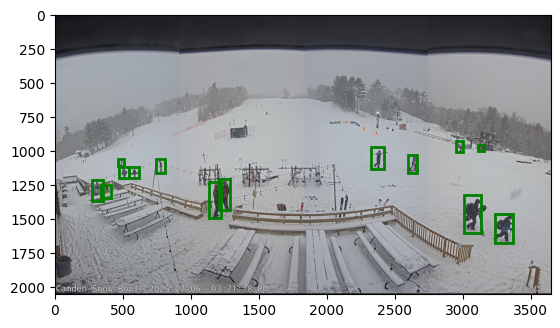

Loading annotations from: datasets/dataset_webcam/labels/train/camdensnowbowl_2025_02_06_15_22_35_000000.txt
Displaying datasets/dataset_webcam/images/train/camdensnowbowl_2025_02_06_15_22_35_000000.jpg.
  Left-click twice to add a box; right-click inside a box to remove it.
  Press 'n' or 'enter' to save and move to the next image, or 'q' to quit.
Could not maximize the window: 'FigureManagerBase' object has no attribute 'window'


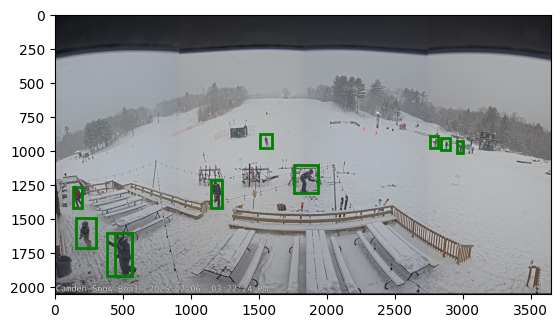

Loading annotations from: datasets/dataset_webcam/labels/train/camdensnowbowl_2025_02_06_15_37_15_000000.txt
Displaying datasets/dataset_webcam/images/train/camdensnowbowl_2025_02_06_15_37_15_000000.jpg.
  Left-click twice to add a box; right-click inside a box to remove it.
  Press 'n' or 'enter' to save and move to the next image, or 'q' to quit.
Could not maximize the window: 'FigureManagerBase' object has no attribute 'window'


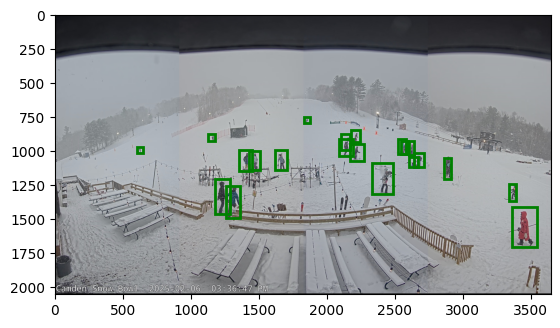

Loading annotations from: datasets/dataset_webcam/labels/train/camdensnowbowl_2025_02_06_15_37_58_000000.txt
Displaying datasets/dataset_webcam/images/train/camdensnowbowl_2025_02_06_15_37_58_000000.jpg.
  Left-click twice to add a box; right-click inside a box to remove it.
  Press 'n' or 'enter' to save and move to the next image, or 'q' to quit.
Could not maximize the window: 'FigureManagerBase' object has no attribute 'window'


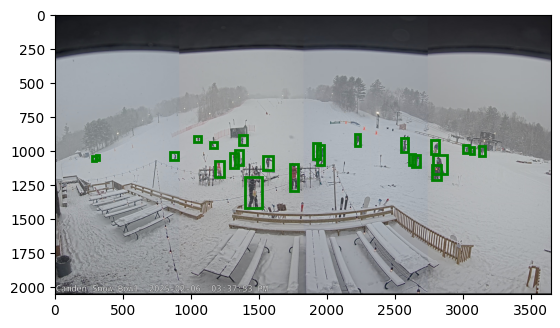

Loading annotations from: datasets/dataset_webcam/labels/train/camdensnowbowl_2025_02_06_16_01_56_000000.txt
Displaying datasets/dataset_webcam/images/train/camdensnowbowl_2025_02_06_16_01_56_000000.jpg.
  Left-click twice to add a box; right-click inside a box to remove it.
  Press 'n' or 'enter' to save and move to the next image, or 'q' to quit.
Could not maximize the window: 'FigureManagerBase' object has no attribute 'window'


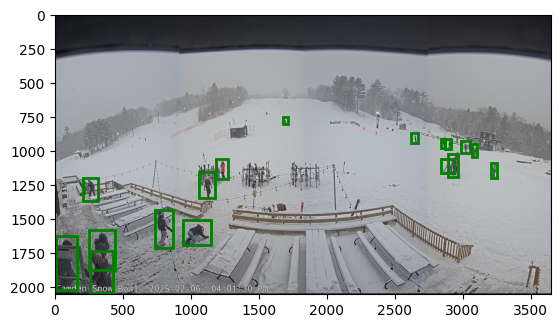

Loading annotations from: datasets/dataset_webcam/labels/train/camdensnowbowl_2025_02_06_16_04_02_000000.txt
Displaying datasets/dataset_webcam/images/train/camdensnowbowl_2025_02_06_16_04_02_000000.jpg.
  Left-click twice to add a box; right-click inside a box to remove it.
  Press 'n' or 'enter' to save and move to the next image, or 'q' to quit.
Could not maximize the window: 'FigureManagerBase' object has no attribute 'window'


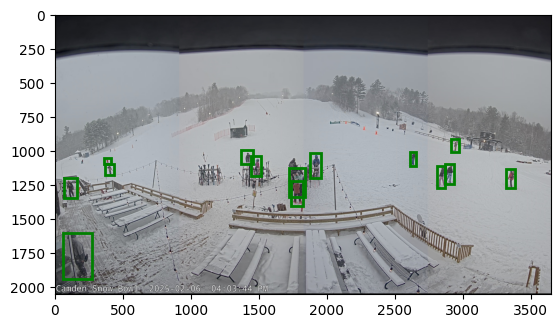

Loading annotations from: datasets/dataset_webcam/labels/train/camdensnowbowl_2025_02_06_16_04_59_000000.txt
Displaying datasets/dataset_webcam/images/train/camdensnowbowl_2025_02_06_16_04_59_000000.jpg.
  Left-click twice to add a box; right-click inside a box to remove it.
  Press 'n' or 'enter' to save and move to the next image, or 'q' to quit.
Could not maximize the window: 'FigureManagerBase' object has no attribute 'window'


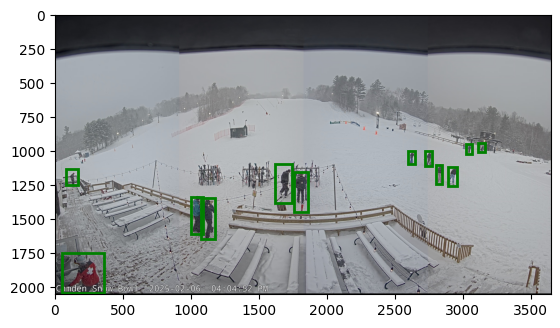

Loading annotations from: datasets/dataset_webcam/labels/train/camdensnowbowl_2025_02_06_16_06_06_000000.txt


KeyboardInterrupt: 

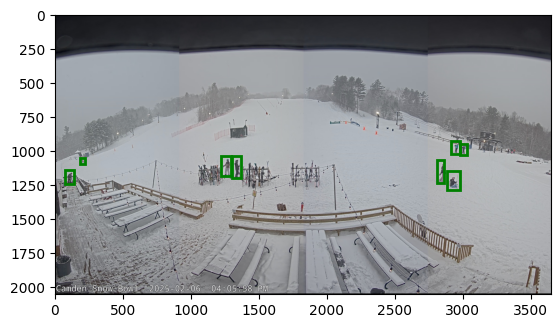

In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2

#from config.config import frame_capture_settings
# =========================
# Helper functions for display
# =========================

def get_yolo_boxes_from_annotation_file(annotation_file):
    boxes = []
    if not os.path.exists(annotation_file):
        print(f"Annotation file not found: {annotation_file}")
        return boxes  # return empty list if no file
    with open(annotation_file, 'r') as f:
        lines = f.readlines()
    for line in lines:
        # Each line: "class_id x_center y_center width height"
        box = line.strip().split(' ')
        if len(box) != 5:
            continue  # skip invalid lines
        box = [float(x) for x in box]
        boxes.append(box)
    return boxes

# =========================
# The interactive BoxEditor class
# Used to add and remove bounding box annotations for each frame interactively. All bounding boxes added will be associated with the target class, defined in the .env file
# =========================

class BoxEditor:
    def __init__(self, ax, fig, boxes, annotation_filename, img_width, img_height, results):
        """
        Parameters:
          ax: matplotlib axes where the image is shown.
          fig: the current figure.
          boxes: a list of boxes in YOLO format [class_id, x_center_norm, y_center_norm, width_norm, height_norm].
          annotation_path: path to the annotation file (to be updated on save).
          img_width, img_height: image dimensions in pixels.
        """
        self.ax = ax
        self.fig = fig
        self.boxes = boxes  # list of boxes in YOLO format
        self.annotation_filename = annotation_filename
        self.img_width = img_width
        self.img_height = img_height
        self.results = results

        # For adding new boxes (left click)
        self.temp_point = None  # stores the first corner (x, y) when left clicking
        self.temp_marker = None  # a temporary marker for the first click

        # A list to hold the drawn rectangle patches for each box
        self.patches = []
        for box in self.boxes:
            patch = self.draw_box(box)
            self.patches.append(patch)
        for result in self.results:
            if result.boxes is not None:
                boxes = result.boxes.data.cpu().numpy()
                for box in boxes:
                    x1, y1, x2, y2, conf, cls = box
                    # In COCO, the 'person' class typically has an id of 0.
                    box = [cls, x1, y1, x2, y2]
                    draw_box(box)    
        

    def draw_box(self, yolo_box):
        """Draw a rectangle for a box in YOLO format and return the patch."""
        class_id = yolo_box[0]
        xc = yolo_box[1] * self.img_width
        yc = yolo_box[2] * self.img_height
        w = yolo_box[3] * self.img_width
        h = yolo_box[4] * self.img_height
        x0 = xc - w/2
        y0 = yc - h/2
        patch = plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=1)
        self.ax.add_patch(patch)
        self.fig.canvas.draw_idle()
        return patch

# =========================
# Key press callback for the editor
# =========================

def on_key_editor(event, editor):
    """
    When 'n' or 'enter' is pressed, save the annotation file and close the figure.
    When 'q' is pressed, save and quit the program.
    """
    if event.key in ['n', 'enter', 'return']:
        editor.disconnect()
        plt.close()
    elif event.key == 'q':
        editor.disconnect()
        plt.close('all')
        sys.exit(0)
    else:
        # Ignore any other keys
        pass

# =========================
# Main display function (modified to include editing)
# =========================

def display_images(folder, model):
    """
    Loop through annotation .txt files in the default_label_dir folder. For each file, 
    display the corresponding image and the existing bounding boxes. 
    Then allow the user to add boxes with left-clicks and remove boxes with right-clicks.
    Press 'n' or 'enter' to save changes and move to the next image,
    or press 'q' to quit the program.
    This will move the annotation files to the edited_label_dir folder and out of the default_label_dir folder.

    """
    for annotation_filename in sorted(os.listdir(folder)):
        if not annotation_filename.lower().endswith('.txt'):
            continue
        annotation_path = os.path.join(folder, annotation_filename)
        # Load image (convert from BGR to RGB)
        img_filename = annotation_filename.replace('.txt', '.jpg')
        img_folder = str(folder).replace('labels', 'images')
        img_path = os.path.join(img_folder, img_filename)
        img = cv2.imread(img_path)
        if img is None:
            continue  # Skip if image cannot be loaded
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Construct the annotation file path.
        print("Loading annotations from:", annotation_path)
        boxes = get_yolo_boxes_from_annotation_file(annotation_path)
        results = model.predict(img, conf=0.4, iou=0.5, device=device)


        # Create figure and axis; display the image.
        fig, ax = plt.subplots()
        ax.imshow(img)
        height, width, _ = img.shape

        # (Optional) Draw the original boxes with your existing function:
        # show_yolo_boxes(boxes, ax, height, width)

        # Create a BoxEditor to enable interactive editing.
        editor = BoxEditor(ax, fig, boxes, annotation_filename, width, height, results)

        # Connect the key press event; we pass the editor to the callback via a lambda.
        fig.canvas.mpl_connect('key_press_event', lambda event: on_key_editor(event, editor))
        print(f"Displaying {img_path}.")
        print("  Left-click twice to add a box; right-click inside a box to remove it.")
        print("  Press 'n' or 'enter' to save and move to the next image, or 'q' to quit.")


        mng = plt.get_current_fig_manager()
        try:
            # First try with state('zoomed')
            mng.window.state('zoomed')
        except Exception:
            try:
                # If that fails, try with attributes
                mng.window.attributes('-zoomed', True)
            except Exception as e:
                print("Could not maximize the window:", e)

        # # Maximize window if possible and show the figure (this call blocks until the figure is closed)
        # mng = plt.get_current_fig_manager()
        # try:
        #     mng.window.showMaximized()
        # except AttributeError:
        #     print(mng.__dict__)
        #     pass  # Some backends may not support this

        plt.show()

# =========================
# Run the viewer/editor
# =========================
folder_path = 'datasets/dataset_webcam/labels/train'

model_path = 'finetune/yolo11l_webcam_finetune/weights/best.pt'
model = YOLO(model_path).to('cuda')
display_images(folder_path, model)
